In [233]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, sys # filesystem operations
import matplotlib.pyplot as plt
import cv2
import random
import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from argparse import Namespace
import tensorflow.keras.datasets
import matplotlib.pyplot

In [234]:
# Preparing MNIST Dataset
(x_train_orig, y_train), (x_test_orig, y_test) = tensorflow.keras.datasets.mnist.load_data()
x_train_orig = x_train_orig.astype("float32") / 255.0
x_test_orig = x_test_orig.astype("float32") / 255.0
x_train = np.reshape(x_train_orig, newshape=(x_train_orig.shape[0], np.prod(x_train_orig.shape[1:])))
x_test = np.reshape(x_test_orig, newshape=(x_test_orig.shape[0], np.prod(x_test_orig.shape[1:])))
print(set(y_train))
class DS():
    def __init__(self, x_data, y_data):
        self.data=x_data
        self.labels=y_data
        self.categories=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        #class_id = torch.as_tensor(self.categories.index(self.labels[idx]), dtype=torch.int64)
        img=self.data[idx]
        return torch.tensor(img), torch.tensor(img)
train_data=DS(x_train, x_train)
test_data=DS(x_test, x_test)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [235]:
# Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.dense_layer1 = nn.Linear(in_features=784, out_features=300)
        self.dense_layer2 = nn.Linear(in_features=300, out_features=4)

    def forward(self, x):
        x = F.leaky_relu(self.dense_layer1(x))
        x = F.leaky_relu(self.dense_layer2(x))
        return x

In [236]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.dense_layer1 = nn.Linear(in_features=4, out_features=300)
        self.dense_layer2 = nn.Linear(in_features=300, out_features=784)

    def forward(self, x):
        x = F.leaky_relu(self.dense_layer1(x))
        x = F.leaky_relu(self.dense_layer2(x))
        return x

In [237]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
myEncoder=Encoder()
myDecoder=Decoder()

In [238]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
myModel = Autoencoder(myEncoder, myDecoder)
myModel = myModel.to(device)
train_dl=torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_dl=torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

In [239]:
def inference (model, val_dl):
    all_preds=[]
    all_labels=[]
    correct_prediction = 0
    total_prediction = 0

    # Disable gradient updates
    with torch.no_grad():
        for data in val_dl:
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Get predictions
            outputs = model(inputs)

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
            
            all_preds.append(prediction.to(torch.device("cpu")))
            all_labels.append(labels.to(torch.device("cpu")))
    acc = correct_prediction/total_prediction
    print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')
    return all_preds, all_labels, acc

In [240]:
testacclist=[]
trainingacclist=[]

In [241]:
def training(model, train_dl, num_epochs, iteration):
    # Loss Function, Optimizer and Scheduler  
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)#01)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0002,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

    # Repeat for each epoch
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0

        # Repeat for each batch in the training set
        for i, data in enumerate(train_dl):
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)
            #print(labels.is_cuda)
            #print(np.shape(inputs))
            # Normalize the inputs
            #inputs_m, inputs_s = inputs.mean(), inputs.std()
            #inputs = (inputs - inputs_m) / inputs_s
            #print(inputs.is_cuda)
            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            #print(outputs.is_cuda)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Keep stats for Loss and Accuracy
            running_loss += loss.item()
        print(running_loss)
        print(epoch)
for i in range(1):
    num_epochs=40
    iteration=i
    training(myModel, train_dl, num_epochs, iteration)
    #trainingacclist.append(trainacc)
    
    #temp1, temp2, testacc=inference(myModel, test_dl)
    #testacclist.append(testacc)
#x_axis = list(range(1, len(testacclist) + 1))
#plt.plot(x_axis, trainingacclist, x_axis, testacclist)

69.9656413756311
0
49.56025554984808
1
44.864938113838434
2
42.38763899356127
3
40.58319192752242
4
38.969721000641584
5
36.74191705696285
6
35.18011920526624
7
34.31420327350497
8
33.699611300602555
9
33.207565043121576
10
32.78668343089521
11
32.402552938088775
12
32.059030044823885
13
31.75795336253941
14
31.495158463716507
15
31.27448088862002
16
31.057022120803595
17
30.870098054409027
18
30.70233784429729
19
30.551954874768853
20
30.41359177418053
21
30.27845099940896
22
30.16613653115928
23
30.050598800182343
24
29.94777464494109
25
29.85122424736619
26
29.76294729858637
27
29.67824352160096
28
29.60676246136427
29
29.53520407155156
30
29.470649756491184
31
29.41112246736884
32
29.355496557429433
33
29.300834205001593
34
29.257470656186342
35
29.212770150974393
36
29.176544316112995
37
29.143038479611278
38
29.1128992959857
39


tensor([ 4.7161,  4.6888,  0.7444, -1.7406], grad_fn=<LeakyReluBackward0>)


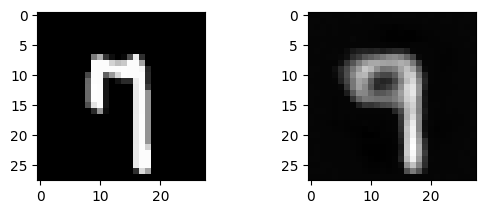

In [282]:
for i, data in enumerate(test_dl):
    # Get the input features and target labels, and put them on the GPU
    inputs, labels = data[0].to(device), data[1].to(device)
    break
#print(inputs.shape)
orig=inputs[0].reshape(28,28)
output=myEncoder(inputs[0])
print(output)
output=myDecoder(output)

output=output.detach().cpu().numpy()
output=output.reshape(28,28)
matplotlib.pyplot.subplot(2, 2, 1)
matplotlib.pyplot.imshow(orig, cmap="gray")
matplotlib.pyplot.subplot(2, 2, 2)
matplotlib.pyplot.imshow(output, cmap="gray")